# Implementacion adicional de FGSM en un modelo de reconocimiento de imagenes de animales 
En el siguiente trabajo, se implementará el ataque de ejemplos adversarios en una red que reconoce tigres, cheetas y hienas


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!pip install unrar

In [4]:
!unrar x /content/dataset.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/dataset.rar

Creating    dataset                                                   OK
Creating    dataset/training                                          OK
Creating    dataset/training/Cheetah                                  OK
Extracting  dataset/training/Cheetah/cheetah_000_resized.jpg               0%  OK 
Extracting  dataset/training/Cheetah/cheetah_001_resized.jpg               0%  OK 
Extracting  dataset/training/Cheetah/cheetah_002_resized.jpg               0%  OK 
Extracting  dataset/training/Cheetah/cheetah_003_resized.jpg               0%  OK 
Extracting  dataset/training/Cheetah/cheetah_004_resized.jpg               0%  OK 
Extracting  dataset/training/Cheetah/cheetah_005_resized.jpg               0%  OK 
Extracting  dataset/training/Cheetah/cheetah_006_resized.jpg               0%  OK 
Extracting  dataset/training/C

Por favor agregar a los archivos el dataset.zip, para poder descomprimirlo y obtener los datos de entrenamiento, validacion y prueba.

Puede descargar el archivo .zip [aquí](https://drive.google.com/drive/folders/12Pmiy3IgHb0ZBfameIOd0shxtZM-aF7L?usp=sharing)

In [5]:
data_dir = '/content/dataset'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/training")
print(len(classes),'classes :', classes)

Folders : ['validation', 'training']
3 classes : ['Tiger', 'Hyena', 'Cheetah']


In [6]:
dataset = ImageFolder(data_dir + '/training', transform=ToTensor())
print('Size of training dataset :', len(dataset))

Size of training dataset : 2700


In [7]:
test = ImageFolder(data_dir + '/validation', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of test dataset : 300


In [8]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 400, 400])


Label:  Cheetah (0)


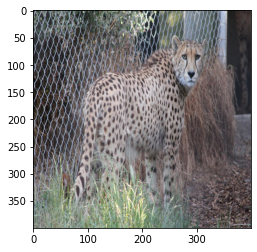

In [9]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[0])

Label:  Tiger (2)


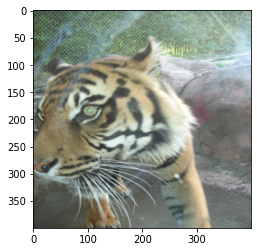

In [10]:
show_example(*dataset[2020])

Label:  Hyena (1)


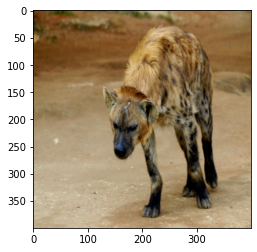

In [11]:
show_example(*dataset[1233])

In [12]:
torch.manual_seed(43)
val_size = 300
train_size = len(dataset) - val_size

In [13]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2400, 300)

In [14]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


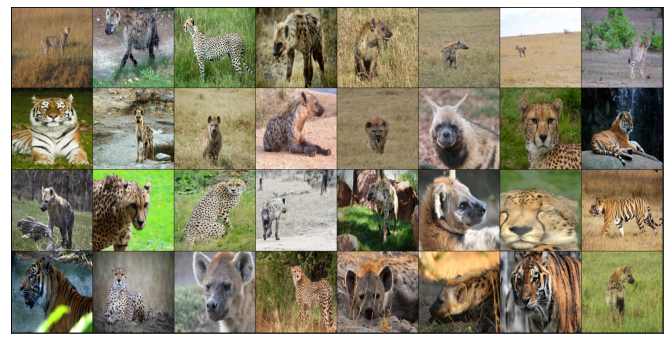

In [15]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [18]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [20]:
device = get_default_device()
device

device(type='cpu')

In [21]:
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

Entrenamiento del modelo



In [22]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [23]:
input_size = 3*400*400
output_size = 3

In [24]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.out_layer = nn.Linear(16, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [25]:
model = to_device(Model(input_size, output_size), device)

In [26]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.34062498807907104, 'val_loss': 1.0997869968414307}]

In [27]:
history += fit(22, 0.02, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.0929, val_acc: 0.3611
Epoch [1], val_loss: 1.1028, val_acc: 0.3259
Epoch [2], val_loss: 1.0999, val_acc: 0.3847
Epoch [3], val_loss: 1.0614, val_acc: 0.4457
Epoch [4], val_loss: 1.1486, val_acc: 0.3398
Epoch [5], val_loss: 1.0548, val_acc: 0.4318
Epoch [6], val_loss: 1.0585, val_acc: 0.4375
Epoch [7], val_loss: 1.0578, val_acc: 0.4315
Epoch [8], val_loss: 1.0451, val_acc: 0.4392
Epoch [9], val_loss: 1.0392, val_acc: 0.4798
Epoch [10], val_loss: 1.0801, val_acc: 0.4182
Epoch [11], val_loss: 1.0406, val_acc: 0.4750
Epoch [12], val_loss: 1.0561, val_acc: 0.3926
Epoch [13], val_loss: 1.0945, val_acc: 0.4506
Epoch [14], val_loss: 1.1070, val_acc: 0.4406
Epoch [15], val_loss: 1.0774, val_acc: 0.4369
Epoch [16], val_loss: 1.1040, val_acc: 0.4318
Epoch [17], val_loss: 1.0575, val_acc: 0.4906
Epoch [18], val_loss: 1.0266, val_acc: 0.4861
Epoch [19], val_loss: 1.0954, val_acc: 0.4489
Epoch [20], val_loss: 1.0313, val_acc: 0.4688
Epoch [21], val_loss: 1.0537, val_acc: 0.389

Evaluación de precisión del modelo

In [28]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

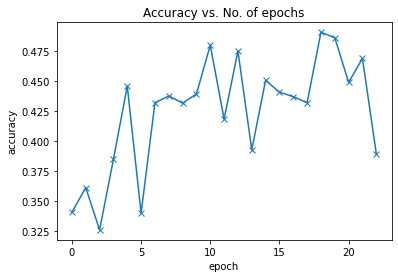

In [29]:
plot_accuracies(history)

Se tiene que un mejor número de epocas seria 21 epocas en lugar de 22

In [30]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

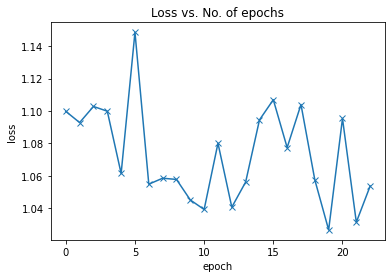

In [31]:
plot_losses(history)

In [32]:
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.4071022868156433, 'val_loss': 1.0416748523712158}

El modelo cuenta con una precisión de 40.7%

In [33]:
model.eval()
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [34]:
# Método para agregar el ruido a la imagen en la creación de adversarios
def fgsm_attack(image, epsilon, data_grad):
    # Obtiene los signos de las gradientes de cada elemento 
    sign_data_grad = data_grad.sign()
    
    # Agrega el ruido a cada pixel sumándole la gradiente multiplicado por epsilon
    # a mayor valor de epsilon será menos reconocible el número de la imagen
    perturbed_image = image + epsilon*sign_data_grad
    
    # Se recortan los valores para mantener los valores de pixeles entre [0,1] 
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [39]:
def Adversarios(test_loader, epsilon ):

    iterador = 1
    correct = 0             #Contador de aciertos del modelo
    uncorrect = 0
    adv_examples = []       #Aquí se guardaran los adversarios generados

    #Se itera sobre todas las imágenes y sus clasificaciones en test_loader
    for data, target in test_loader:

        # Se obtiene la imagen y su respectiva clasificación
        data, target = data, target

        # Se especifica que se guarden las gradientes de los cálculos por la red. Luego usaremos las gradientes en la perturbacion de imagenes
        data.requires_grad = True

        # Paso Forward, la red neuronal procesa la imagen y obtiene la clasificación de la imagen 
        output = model(data)
        

        # Si la red neuronal se equivoca con la clasificación, ya no hay porque modificar esa imagen, se pasa a la siguiente
        #if init_pred.item() != target.item():
        #    continue

        # Evaluamos que tan bien la red neuronal clasificó nuestra imagen mediante la función de pérdida
        loss = F.nll_loss(output, target)

        # Limpiamos las gradientes para no arrastrar esos cálculos y no altere nuestros pesos calculados
        # NOTA: borro las gradientes del modelo porque las gradientes están dentro de los parámetros del modelo, así que este proceso también  
        #       lo puede ejecutar el optimizador ya que tiene acceso a los parametros y , por ende, a las gradientes
        model.zero_grad()

        # Paso Backward, se hace un paso hacia atrás para evaluar las derivadas parciales del proceso
        loss.backward()

        # Se almacenan las gradientes para luego usarlas en la generación de adversarios
        data_grad = data.grad.data

        # Se agrega el ruido a la imagen 
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Se vuelve a probar si ahora la red neuronal se equivoca frente a la imagen con ruido
        output1 = model(perturbed_data)

        acc = accuracy(output, target)
        acc1 = accuracy(output1, target)
        if iterador % 10 == 0 and acc == 1 and acc1 != 1:
          
          print("Precision antes del ataque: {:.4f}" .format(acc))
          print("Precision luego del ataque: {:.4f}" .format(acc1))

        iterador += 1

    return True

In [40]:
accuracies = []       #Lista de clasificaciones correctas del modelo
examples = []         #Lista de ejemplos adversarios

#Para cada valor de epsilon en epsilons[] se generan adversarios y se prueba el rendimiento de la red 
# frente a estos
for eps in epsilons:
    x = Adversarios(test_loader, eps)
    print(x)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


True
True
True
True
True
True
True


# Implementacion incompleta